## Training a Neural Network Using Keras

In this demo, we will show you how to train a traditional feedforward neural network using Keras in TensorFlow. We will implement a neural network for binary classification with three hidden layers and train the network using a form of the optimization algorithm gradient descent called stochastic gradient descent (SGD).

For more information about Keras, consult the [online documentation](https://keras.io/api/).
TensorFlow is a general purpose high-performance computing language which Keras is built on top of to allow us to easily define and train neural networks.


### Import Packages
To get started, let us import Keras, along with other libraries.

In [1]:
import numpy as np
import pandas as pd
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2" # suppress info and warning messages
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time 
import tensorflow.keras as keras

## Create and Visualize a Data Set

Rather than using an imported data set, we will create dummy data to use for training and testing.

Our data set will consists of 600 examples. Each example contains two features `x1` and `x2`. The label `y` is either 0 or 1. For this demo, we created our data set to contain 300 examples belonging to class 0 and 300 examples belonging to class 1.

Run the code cells below to inspect and visualize the data.

In [2]:
# The data contains 600 examples total
# 300 in class 0 
# 300 in class 1

# Generate the raw data
N = 300
r = np.linspace(1,2*np.pi,N)
x1 = np.array([np.sin(2.*r)*r, np.cos(2*r)*r]).T
x2 = np.array([np.sin(2.*r+np.pi)*r, np.cos(2*r+np.pi)*r]).T

# Compute X and y
X = np.concatenate([x1, x2], axis=0)
print("X shape:")
print(X.shape)
y = np.concatenate([np.ones(N), 0 * np.ones(N)])

# Create DataFrame for visualizaton purposes
df = pd.DataFrame({
    'x1': X[:,0],
    'x2': X[:,1],
    'y': y
})
df.head()

X shape:
(600, 2)


,x1,x2,y
0,0.909297,-0.416147,1.0
1,0.909824,-0.455930,1.0
2,0.908654,-0.496261,1.0
3,0.905752,-0.537067,1.0
4,0.901081,-0.578277,1.0


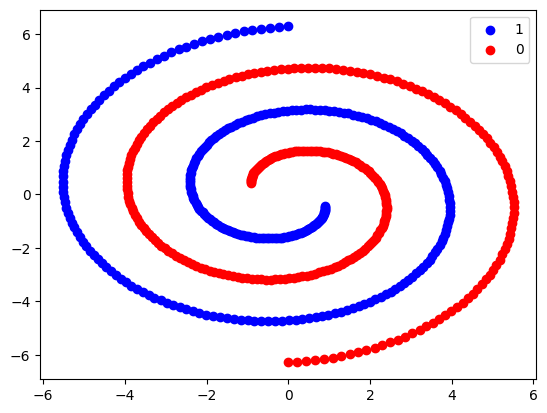

In [3]:
# Visualize data
plt.scatter(X[y == 1, 0], X[y == 1, 1], c='b')
plt.scatter(X[y != 1, 0], X[y != 1, 1], c='r')
plt.legend(["1","0"])
plt.show()

##  Create Training and Test Data Sets
We will now use scikit-learn to split our data set into training and test data sets.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)
print(X_train.shape)
print(X_test.shape)

(420, 2)
(180, 2)


## Implement a Neural Network

The steps to implement a neural network model using Keras are:

1. Construct the Neural Network:
    1. Define the model structure.
    2. Define the optimization algorithm, i.e., the variant of gradient descent you want to use.
    3. Define the loss function to minimize.
    4. Compile the model.
2. Train the neural network:<br>
    "Fit" the model to the training data for $M$ epochs (an epoch is one training cycle, which is one forward and backward propagation pass of all of the training data). This training process propagates the data forward, computing the loss value, then propagates the data backward, computing the gradients for the weights, and then updating the weights for $M$ times. 

3. Evaluate the model's performance.


We will walk you through these steps.

## Part 1. Construct the Neural Network

### Step 1. Define Model Structure

We will use the Keras [Sequential class](https://keras.io/api/models/sequential/) to group a stack of layers. We will use the [InputLayer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/InputLayer) class to create the input layer. We will use the [Dense class](https://keras.io/api/layers/core_layers/dense/) to create each hidden layer and the output layer. A dense layer is also known as a fully-connected layer. Dense layers are made up of nodes that connect to every node in the previous layer. Dense layers perform linear transformations on the input data, followed by a non-linear activation function.

To create a neural network in Keras we have to specify the type and width of each hidden layer as well as the activation function we would like to use. We will create a network with 3 hidden layers of width 64, 32, and 16 and will use the ReLU activation function.


In [5]:
# Create neural network model object
nn_model = keras.Sequential()

# Construct input layer 
input_layer = keras.layers.InputLayer(input_shape=(2,), name='input')
# Add input layer to model object
nn_model.add(input_layer)


# Construct hidden layer 1
hidden_layer_1 = keras.layers.Dense(units=64, activation='relu', name='hl_1')
# Add hidden layer to model object
nn_model.add(hidden_layer_1)


# Construct hidden layer 2
hidden_layer_2 = keras.layers.Dense(units=32, activation='relu', name='hl_2')
# Add hidden layer to model object
nn_model.add(hidden_layer_2)


# Construct hidden layer 3
hidden_layer_3 = keras.layers.Dense(units=16, activation='relu', name='hl_3')
# Add hidden layer to model object
nn_model.add(hidden_layer_3)


# Construct Output layer 
output_layer = keras.layers.Dense(units=1, activation='sigmoid', name='output') 
# Add output layer to model object
nn_model.add(output_layer)


# Print model summary
nn_model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hl_1 (Dense)                 (None, 64)                192       
_________________________________________________________________
hl_2 (Dense)                 (None, 32)                2080      
_________________________________________________________________
hl_3 (Dense)                 (None, 16)                528       
_________________________________________________________________
output (Dense)               (None, 1)                 17        
Total params: 2,817
Trainable params: 2,817
Non-trainable params: 0
_________________________________________________________________


Let's break this down. Our network is comprised of 5 layers: an input layer, three hidden layers and an output layer.
The code above creates the hidden and output layers.


<b>Input layer</b>

We pass the following arguments to the `InputLayer()` function:

`input_shape`: dimensionality of the input layer.<br>

* When specifying an input shape of 2, we are specifying the input layer's dimensions. The input layer has 2 dimensions to match the number of features (2 features) in each of the training examples in $\mathbf{X}$.

Note that we do not have to explicitly use the Keras `InputLayer` to create an input layer.

We can remove the lines:

```
input_layer = keras.layers.InputLayer(input_shape=(2,), name='input')
model.add(input_layer)
```
and instead move the `input_shape` parameter to the first hidden layer, like so: 

```
hidden_layer_1 = keras.layers.Dense(units=64, input_shape=(2,), activation='relu', name='hl_1')
```

This effectively combines both layers. In fact, it is generally recommended to use this second approach, but for the purposes of this course we will create an `InputLayer` in Keras.


<b>Hidden layers</b>

Once you have an Input layer, the next step is to add Dense layers. We pass the following arguments to the `Dense()` function:

    
`activation`: activation function to use. If you don't specify anything, no activation is applied (i.e., "linear" activation: $a(x) = x$).<br>

* In this demo, we are specifying ReLU as the activation function. 

`units`: dimensionality of the output space. We can view this as the number of nodes in the layer itself.<br>

   *  When specifying the number of units in the first hidden layer to be 64, we are specifying a fully-connected layer with 64 hidden units (nodes). Note that we can choose the value of `units`. This is a hyperparameter we can tune.


<b>Output Layer</b>:

`units`: The output layer is a single dense layer. The output shape is 1. We have a single node that outputs one numerical value.

`activation`:
Note that we are specifying an activation function: sigmoid. Since we are working with binary classification, we will be using the sigmoid activation function to map the output to a probability between 0.0 and 1.0. We can later set a threshold and assume that the prediction is class 1 if the probability is larger than or equal to our threshold, or class 0 if it is lower than our threshold.

#### Classification Neural Network Output


Neural networks are versatile models that can be used to for both regression and classification problems. The output of a regression network is a real number or vector of real numbers. Meanwhile, the output of a neural network for classification is a normalized probability vector.

Classification problems output belief vectors, also known as logits. Every element in the belief vector corresponds to the model's belief that the input example belongs to a certain class. For example, imagine we have a 5-class classification problem with labels {0, 1, 2, 3, 4}. Our model will output a 5-dimensional belief vector. If the 𝑗th element of this vector has the highest value, then the model believes that that example belongs to class 𝑗.

Note that since the output of a classification neural network is a real vector, each element could be any value on different scales. As such, we usually apply an activation function to the output layer which normalizes these values across classes and then turns all outputs into well-defined probabilities. 

If we were working with multi-class classification, we would use the softmax activation function and specify an output shape corresponding to the number of classes (one node per class). A vector would be output which would correspond to the probabilities of each class. 

For our binary classification problem, we could technically also use the softmax activation function and specify an output shape of 2 (two nodes). A vector of size two would be output. However, the best approach would be to use
the sigmoid activation function to output one value - a probability between 0 and 1. 

Note that in Keras, there a number of configurations that can be used to achieve the same goal. You do not have to specify an activation function in the output layer, but rather allow for the output to be logits. You can then use other techniques to achieve a normalized probability output.

### Step 2. Define the Optimization Algorithm

As our optimizer we will use stochastic gradient descent (SGD) with a learning rate of 0.1.

Keras does not provide vanilla gradient descent. Instead, the basic variant it provides is Stochastic Gradient Descent (SGD). For more information, see the [SGD online documentation](https://keras.io/api/optimizers/sgd/). 

In [6]:
sgd_optimizer = keras.optimizers.SGD(learning_rate=0.1)

### Step 3. Define the Loss Function

Since we are working with a binary classification problem, we are going to use log loss, or binary cross entropy loss. We will use the `BinaryCrossentropy` class. Since our output will be a normalized probability between 0 and 1, we specify `from_logits=False`. For more information on the binary cross entropy loss functions in Keras visit the [BinaryCrossentropy online documentation](https://keras.io/api/losses/probabilistic_losses/).

In [7]:
loss_fn = keras.losses.BinaryCrossentropy(from_logits=False)

### Step 4. Compile the model

Now we need to package the network architecture with the optimizer and the loss function and to do this we use the `compile()` method. Notice we are also including the `metrics` parameter. This is a list of metrics to be evaluated by the model during training and testing. We will specify `accuracy` since we would like to obtain the accuracy score.

In [8]:
nn_model.compile(optimizer=sgd_optimizer, loss=loss_fn, metrics=['accuracy'])

## Part 2. Fit the Model to the Training Data

We are almost ready to train the neural network model. By default, Keras will output the loss and accuracy at the end of every epoch. So instead, we will use a custom logger function to only output every 50 epochs.

In [9]:
class ProgBarLoggerNEpochs(keras.callbacks.Callback):
    
    def __init__(self, num_epochs: int, every_n: int = 50):
        self.num_epochs = num_epochs
        self.every_n = every_n
    
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.every_n == 0:
            s = 'Epoch [{}/ {}]'.format(epoch + 1, self.num_epochs)
            logs_s = ['{}: {:.4f}'.format(k.capitalize(), v)
                      for k, v in logs.items()]
            s_list = [s] + logs_s
            print(', '.join(s_list))

Now we can run the `fit()` method on our model to learn model parameters from the training data. The `fit()` method returns a Keras `History` object, which contains information such as the training loss and accuracy per epoch. Also notice that we are adding our logger function to the list of callbacks.

In [10]:
t0 = time.time() # start time

num_epochs = 500 # number of epochs

history = nn_model.fit(
    X_train,
    y_train,
    epochs=num_epochs,
    verbose=0, # disable the default progress bar
    callbacks=[ProgBarLoggerNEpochs(num_epochs, every_n=10)],
)

t1 = time.time() # stop time

print('Elapsed time: %.2fs' % (t1-t0))

Epoch [10/ 500], Loss: 0.6588, Accuracy: 0.6119
Epoch [20/ 500], Loss: 0.6545, Accuracy: 0.6714
Epoch [30/ 500], Loss: 0.6472, Accuracy: 0.6714
Epoch [40/ 500], Loss: 0.6316, Accuracy: 0.6738
Epoch [50/ 500], Loss: 0.6098, Accuracy: 0.6619
Epoch [60/ 500], Loss: 0.5736, Accuracy: 0.6786
Epoch [70/ 500], Loss: 0.4924, Accuracy: 0.6881
Epoch [80/ 500], Loss: 0.3691, Accuracy: 0.8476
Epoch [90/ 500], Loss: 0.2460, Accuracy: 0.8929
Epoch [100/ 500], Loss: 0.1037, Accuracy: 0.9786
Epoch [110/ 500], Loss: 0.0369, Accuracy: 1.0000
Epoch [120/ 500], Loss: 0.0324, Accuracy: 1.0000
Epoch [130/ 500], Loss: 0.0153, Accuracy: 1.0000
Epoch [140/ 500], Loss: 0.0077, Accuracy: 1.0000
Epoch [150/ 500], Loss: 0.0055, Accuracy: 1.0000
Epoch [160/ 500], Loss: 0.0040, Accuracy: 1.0000
Epoch [170/ 500], Loss: 0.0031, Accuracy: 1.0000
Epoch [180/ 500], Loss: 0.0025, Accuracy: 1.0000
Epoch [190/ 500], Loss: 0.0021, Accuracy: 1.0000
Epoch [200/ 500], Loss: 0.0019, Accuracy: 1.0000
Epoch [210/ 500], Loss: 0.001

It is possible that the Keras model takes longer to train than a version built from scratch with basic NumPy. This is because of the massive overhead required to setup and train the model. However, as the number of training examples increases and the network becomes more complex, Keras (and other Machine Learning libraries) scale much better than pure-NumPy implementations &mdash; even better when you use a GPU. For this reason, developers and researchers almost always use libraries like TensorFlow and Keras to train networks.

## Part 3. Evaluate the Model's Performance

Let us visualize the training loss and accuracy over time:

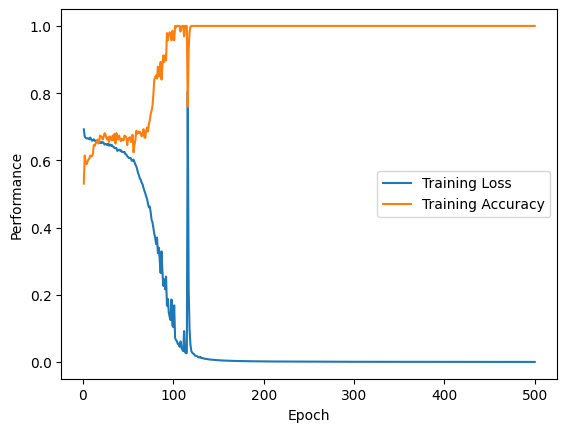

In [11]:
plt.plot(range(1, num_epochs + 1), history.history['loss'], label='Training Loss')
plt.plot(range(1, num_epochs + 1), history.history['accuracy'], label='Training Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Performance')
plt.legend()
plt.show()

Keras makes the process of evaluating our model very easy. Recall that when we compiled the model we specified the metric we wanted to use to evaluate the model: accuracy. The Keras method `evaluate()` will return the loss and accuracy score of our model on the test data:

In [12]:
loss, accuracy = nn_model.evaluate(X_test, y_test, verbose=0)
print('Loss: ', str(loss) , 'Accuracy: ', str(accuracy))

Loss:  0.0006575475563295186 Accuracy:  1.0


In the cell below, we will make a prediction on our test set using the `predict()` method, receive a probability between 0.0 and 1.0, and then apply a threshold to obtain the the predicted class for each example. We will use a threshold of 0.5.

For the first 10 examples, we will output their probabilities and the corresponding classes. Examine the output to see how this works.

In [13]:
# Make predictions on the test set
probability_predictions = nn_model.predict(X_test)
print("Predictions for the first 10 examples:")
print("Probability\t\t\tClass")
for i in range(0,10):
    if probability_predictions[i] >= 0.5:
        class_pred = 1
    else:
        class_pred = 0
    print(str(probability_predictions[i]) + "\t\t\t" + str(class_pred))

Predictions for the first 10 examples:
Probability			Class
[0.00012666]			0
[1.04390465e-05]			0
[0.00032091]			0
[0.00028172]			0
[0.9999788]			1
[0.00034395]			0
[0.00159845]			0
[0.99970627]			1
[5.317264e-05]			0
[0.9998582]			1


### Visualize the Learned Decision Boundaries

Finally, since this example is a binary classification problem, we can visualize the decision boundaries that the model learned:

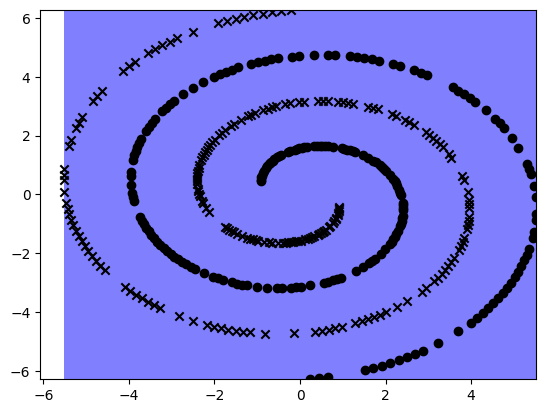

In [14]:
from numpy.matlib import repmat

symbols = ["ko","kx"]
marker_symbols = ['o', 'x']
mycolors = [[0.5, 0.5, 1], [1, 0.5, 0.5]]
classvals = np.unique(y_train)

plt.figure()

res=300
xrange = np.linspace(min(X_test[:, 0]), max(X_test[:, 0]),res)
yrange = np.linspace(min(X_test[:, 1]), max(X_test[:, 1]),res)
pixelX = repmat(xrange, res, 1)
pixelY = repmat(yrange, res, 1).T


xTe = np.array([pixelX.flatten(), pixelY.flatten()]).T
logits = nn_model.predict(xTe, steps = 1)
testpreds = logits.argmax(axis = 1)

testpreds[testpreds == 0] = -1
Z = testpreds.reshape(res, res)
#Z[0,0] = 1 # optional: scale the colors correctly
plt.contourf(pixelX, pixelY, np.sign(Z), colors=mycolors)

for idx, c in enumerate(classvals):
    plt.scatter(X_train[y_train == c,0],
                X_train[y_train == c,1],
                marker=marker_symbols[idx],
                color='k')

plt.axis('tight')
plt.show()



## Deep Dive:

You can play around with the neural network implementation above and compare your results every time you train the network. Pay attention to the time it takes to train the network, and the resulting loss and accuracy. 

Below are some ideas for things you can try:

* Adjust the learning rate.
* Change the number of epochs by experimenting with different values for the variable `num_epochs`.
* Add more hidden layers and/or experiment with different values for the `unit` parameter in the hidden layers to change the number of nodes in the hidden layers.
* Modify the data set.